Import necessary packages:

In [1]:
import pandas as pd
import numpy as np
#import xlsxwriter
#import xlrd
from io import StringIO as sio
import matplotlib.pyplot as mplt
from plotnine import ggplot, aes, geom_line, geom_bar, geom_label, facet_grid, geom_point, geom_text, theme, element_rect
from plotnine import labs, scale_x_timedelta, scale_x_continuous, scale_y_discrete, annotate, scale_y_continuous
from sklearn.linear_model import LinearRegression

Import .txt data, rename variables, and convert names to lower case and print head of data.

In [2]:
pvcost = pd.read_csv("PV system Cost.txt",
                     sep = "\t",
                     skiprows = 6,
                     skipfooter = 0,
                     index_col = False,
                     #names = ["AV Types", "Item", "Cost ($)", "Panel Height (ft.)", "total Cost ($)"],
                     #colspecs= [(0, 13), (14, 23), (24, 32), (33, 51), (51, 70)]
                     )
pvcost.columns = pvcost.columns.str.lower()
pvcost = pvcost.rename(
    columns={
        "av types":"avtypes",
        "item": "item",
        "cost ($)": "cost",
        "panel height (ft.)": "pheight",
        "total cost ($)": "tcost"
        }
    )
print(pvcost.head())
print(pvcost.tail())

            avtypes                      item  cost  pheight  tcost
0  Typical Fixed PV  EPC/Developer Net Profit  0.11      4.6   1.53
1  Typical Fixed PV        Developer Overhead  0.15      4.6   1.53
2  Typical Fixed PV           Contingency(3%)  0.05      4.6   1.53
3  Typical Fixed PV       Interconnection Fee  0.03      4.6   1.53
4  Typical Fixed PV   Permitting Fee (if any)  0.02      4.6   1.53
                                   avtypes                         item  cost  \
103  PV + Crops (Reinforced Regular Mount)  Installation and Labor Cost  0.32   
104  PV + Crops (Reinforced Regular Mount)               Electrical BOS  0.38   
105  PV + Crops (Reinforced Regular Mount)               Structural BOS  0.32   
106  PV + Crops (Reinforced Regular Mount)                Inverter Only  0.08   
107  PV + Crops (Reinforced Regular Mount)                       Module  0.40   

     pheight  tcost  
103      8.2   2.33  
104      8.2   2.33  
105      8.2   2.33  
106      8.2   2.

Unique values of avtypes variable in pvcost dataframe:

In [3]:
pvcost['avtypes'].unique()

array(['Typical Fixed PV', 'Typical 1-AT PV', 'Fixed PV + Grazing',
       'Tracker PV + Grazing', 'Fixed PV + Pollinator',
       'Tracker PV + Pollinator', 'PV + Crops (Vertical Mount)',
       'PV + Crops (Tracker Stilt Mount)',
       'PV + Crops (Tracker Stilt Mount)     ',
       'PV + Crops (Reinforced Regular Mount)'], dtype=object)

Create a new variables called "tracker" based on above unique values of avtypes in pvcost and print some observations to know if trackers are correctly classified.

In [4]:
# Define function to classify values
def classify_value(x):
    if x == "Typical Fixed PV":
        return "Fixed"
    elif x == "Typical 1-AT PV":
        return "Tracking"
    elif x == "Fixed PV + Grazing":
        return "Fixed"
    elif x == "Tracker PV + Grazing":
        return "Tracking"
    elif x == "Fixed PV + Pollinator":
        return "Fixed"
    elif x == "Tracker PV + Pollinator":
        return "Tracking"
    elif x == "PV + Crops (Vertical Mount)":
        return "Fixed"
    elif x == "PV + Crops (Tracker Stilt Mount)":
        return "Tracking"
    elif x == "PV + Crops (Tracker Stilt Mount)":
        return "Trakcing"
    elif x == "PV + Crops (Reinforced Regular Mount)":
        return "Fixed"
    elif x == "PV + Crops (Tracker Stilt Mount)     ":
        return "Tracking"
    else:
        return "Unclassified"

# Add 'classification' column based on conditions
pvcost['tracker'] = pvcost['avtypes'].apply(classify_value)

# Display the updated DataFrame
#print(pvcost.head())
#print(pvcost.tail())
print(pvcost.loc[8:16, ] )

             avtypes                      item  cost  pheight  tcost   tracker
8   Typical Fixed PV            Electrical BOS  0.24      4.6   1.53     Fixed
9   Typical Fixed PV            Structural BOS  0.11      4.6   1.53     Fixed
10  Typical Fixed PV             Inverter Only  0.08      4.6   1.53     Fixed
11  Typical Fixed PV                    Module  0.40      4.6   1.53     Fixed
12   Typical 1-AT PV  EPC/Developer Net Profit  0.12      4.6   1.66  Tracking
13   Typical 1-AT PV        Developer Overhead  0.16      4.6   1.66  Tracking
14   Typical 1-AT PV           Contingency(3%)  0.05      4.6   1.66  Tracking
15   Typical 1-AT PV       Interconnection Fee  0.03      4.6   1.66  Tracking
16   Typical 1-AT PV   Permitting Fee (if any)  0.02      4.6   1.66  Tracking


Basic information about the dataframe:

In [5]:
# Display basic information about the DataFrame
print("Dataset Info:")
print(pvcost.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   avtypes  108 non-null    object 
 1   item     108 non-null    object 
 2   cost     108 non-null    float64
 3   pheight  108 non-null    float64
 4   tcost    108 non-null    float64
 5   tracker  108 non-null    object 
dtypes: float64(3), object(3)
memory usage: 5.2+ KB
None


Descriptive statistics for numerical columns

In [6]:
# Generate descriptive statistics for numerical columns
print("Descriptive Statistics:")
print(pvcost.describe().round(2))

Descriptive Statistics:
         cost  pheight   tcost
count  108.00    108.0  108.00
mean     0.15      5.6    1.80
std      0.11      1.5    0.24
min      0.02      4.6    1.53
25%      0.06      4.6    1.63
50%      0.13      4.6    1.73
75%      0.22      6.4    1.83
max      0.40      8.2    2.33


Cost per item for various tracking system and panel heights.

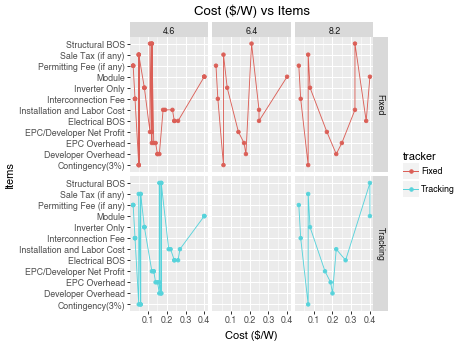

In [7]:
# Cost per item for Various tracking system and panel heights.
(
    ggplot(pvcost)
    + facet_grid("tracker~pheight")
    + aes(y = "item",
          x = "cost",
          color="tracker",
          group="tracker")
    + geom_point()
    + geom_line()
    + labs(title= "Cost ($/W) vs Items",
           y = "Items",
           x = "Cost ($/W)")
)

Total cost for various tracking system and panel heights agrivoltaic systems.

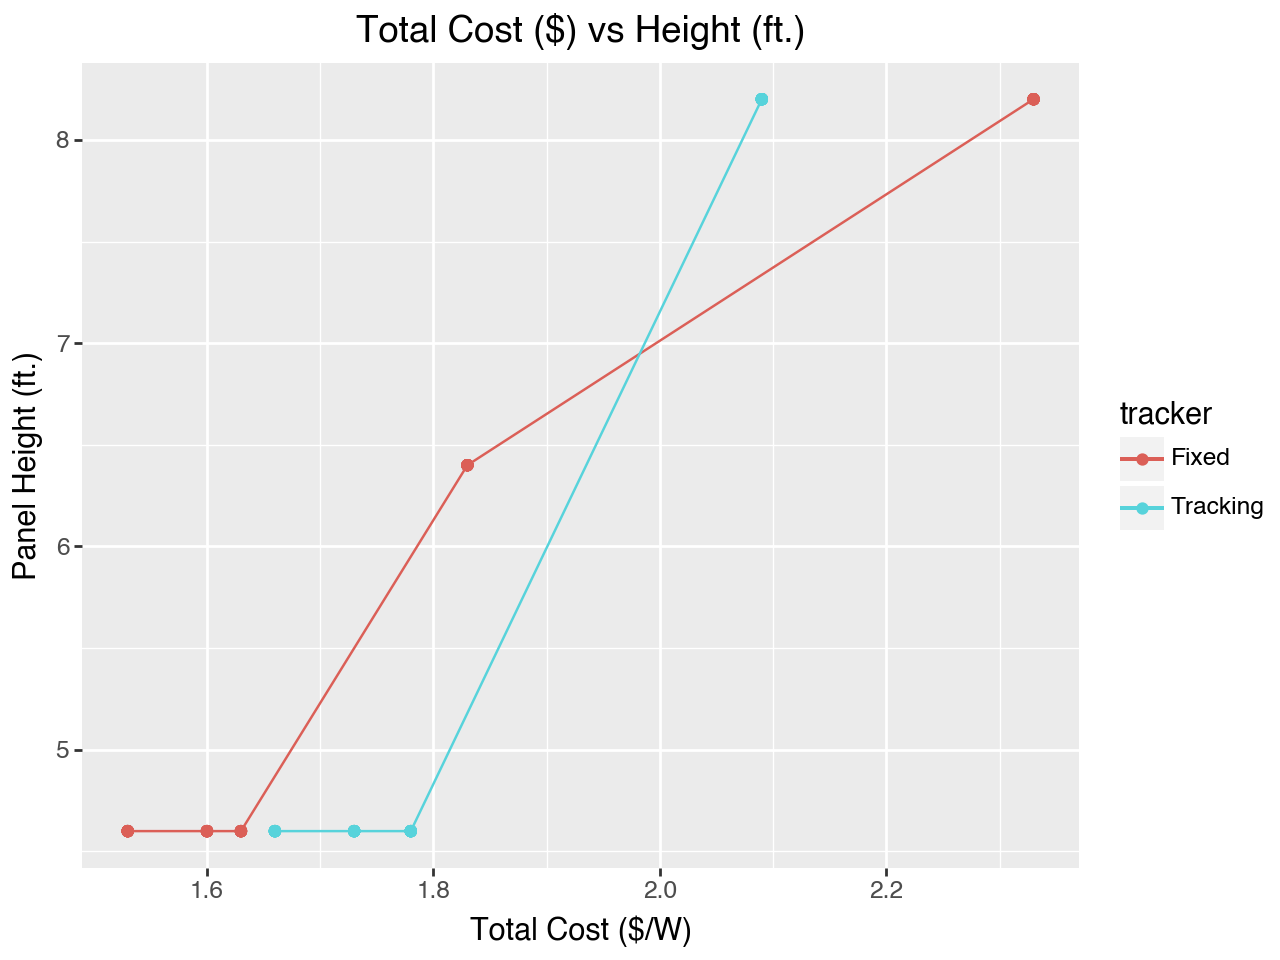

In [8]:
# Total Cost vs Height:
(
    ggplot(pvcost)
    #+ facet_grid("tracker~pheight")
    + aes(y = "pheight",
          x = "tcost",
          color = "tracker",
          group = "tracker")
    + geom_point()
    + geom_line()
    + labs(title= "Total Cost ($) vs Height (ft.)",
           y = "Panel Height (ft.)",
           x = "Total Cost ($/W)")
)

There are more than one observations for same facet in above charts. So, lets narrow them down and create one observation per facet.To do so lets summarize the data and generate some information about the data in successive codes.

In [9]:
avgcost = pvcost.groupby(["pheight", "item", "tracker"])["cost"].mean().reset_index().round(2)
#avgcost = pvcost.groupby(["pheight", "item", "tracker"])["cost"].agg(np.mean).reset_index().round(2)
avgcost = pd.DataFrame(avgcost)
print(avgcost.head())
#print(avgcost)

   pheight                item   tracker  cost
0      4.6     Contingency(3%)     Fixed  0.05
1      4.6     Contingency(3%)  Tracking  0.06
2      4.6  Developer Overhead     Fixed  0.15
3      4.6  Developer Overhead  Tracking  0.17
4      4.6        EPC Overhead     Fixed  0.13


In [10]:
print(avgcost.describe().round(2))

       pheight   cost
count    60.00  60.00
mean      6.40   0.16
std       1.62   0.12
min       4.60   0.02
25%       4.60   0.06
50%       6.40   0.15
75%       8.20   0.24
max       8.20   0.40


In [11]:
print(avgcost.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pheight  60 non-null     float64
 1   item     60 non-null     object 
 2   tracker  60 non-null     object 
 3   cost     60 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.0+ KB
None


Here, we have one observation per facet for one item. Lets make a few plots.

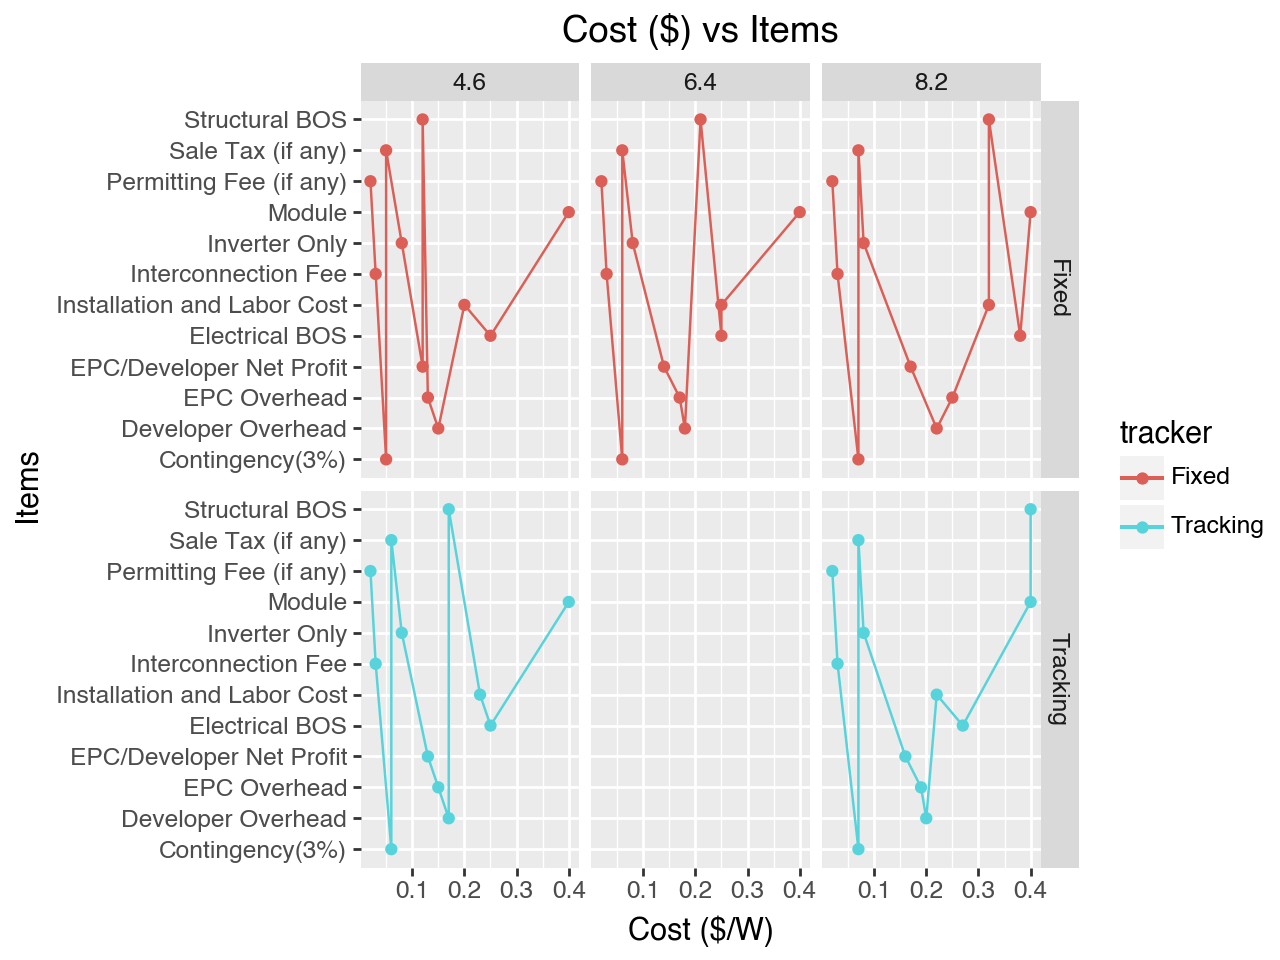

In [12]:
(
    ggplot(avgcost)
    + facet_grid("tracker~pheight")
    + aes(y = "item",
          x = "cost",
          color="tracker",
          group="tracker")
    + geom_point()
    + geom_line()
    + labs(title= "Cost ($) vs Items",
           y = "Items",
           x = "Cost ($/W)")
)

In [13]:
totalcost = avgcost.groupby(["pheight", "tracker"])["cost"].sum().reset_index().round(2)
print(totalcost)

   pheight   tracker  cost
0      4.6     Fixed  1.60
1      4.6  Tracking  1.75
2      6.4     Fixed  1.85
3      8.2     Fixed  2.33
4      8.2  Tracking  2.11


Predict cost at pheight = 6.4 and tracker = tracking.

In [14]:
totalcost = pd.get_dummies(totalcost, columns=['tracker'], drop_first=True)
model = LinearRegression()

# Create and fit the model
model = LinearRegression()
model.fit(totalcost[['pheight', 'tracker_Tracking']], totalcost['cost'])

# Predict cost for pheight = 6.4 and tracker = Tracking
pheight_value = 6.4
tracker_value = 1  # 1 for 'Tracking'

predicted_cost = model.predict([[pheight_value, tracker_value]])
print(f"Predicted cost at pheight = {pheight_value} and tracker = 'Tracking': {predicted_cost[0]:.2f}")

predicted_cost = model.predict([[pheight_value, tracker_value]])[0].round(2)

# Create a DataFrame for the new row
new_row = pd.DataFrame({'pheight': [pheight_value], 'tracker_Tracking': [tracker_value], 'cost': [predicted_cost]})

# Append the new row to the original DataFrame using pd.concat
totalcost = pd.concat([totalcost, new_row], ignore_index=True)

# Convert back to original format
totalcost['tracker'] = totalcost['tracker_Tracking'].apply(lambda x: 'Tracking' if x == 1 else 'Fixed')
totalcost.drop(columns=['tracker_Tracking'], inplace=True)

print(totalcost)

Predicted cost at pheight = 6.4 and tracker = 'Tracking': 1.93
   pheight  cost   tracker
0      4.6  1.60     Fixed
1      4.6  1.75  Tracking
2      6.4  1.85     Fixed
3      8.2  2.33     Fixed
4      8.2  2.11  Tracking
5      6.4  1.93  Tracking


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names


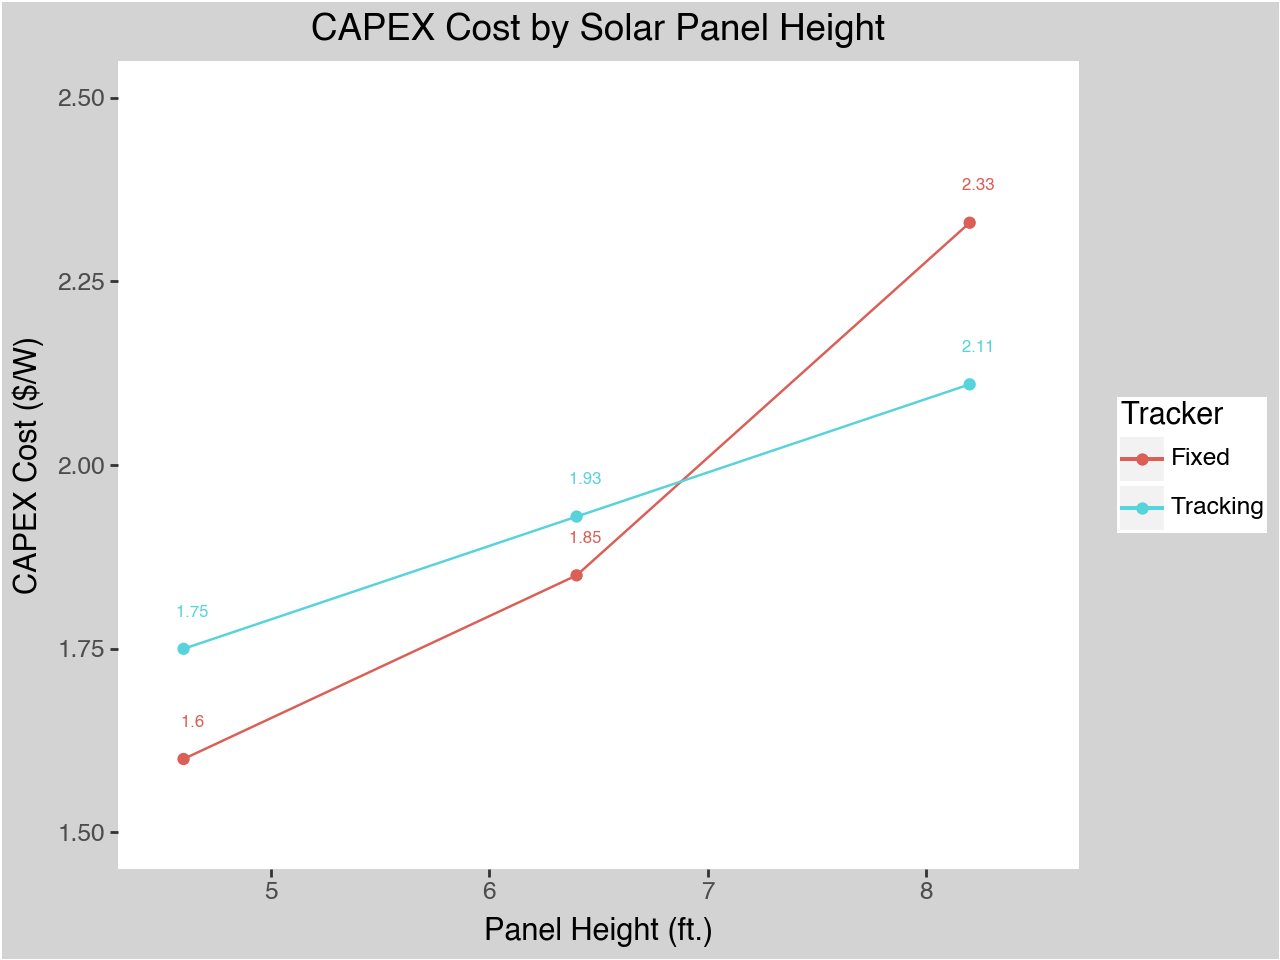

In [15]:
# Assuming totalcost is your DataFrame
totalcost['label'] = totalcost.apply(lambda row: f"{row['cost']} ", axis=1)
plot = (
    ggplot(totalcost)
    #+ facet_grid("tracker~pheight")
    #+ aes(y='cost', x='pheight')
    + aes(x = "pheight",
          y = "cost",
          color = "tracker",
          group = "tracker")
    + geom_point()
    + geom_line()
    + geom_text(aes(label='label'), 
                nudge_x=0.05, 
                nudge_y=0.05, 
                size=6)
    + labs(title="CAPEX Cost by Solar Panel Height",
           x="Panel Height (ft.)",
           y="CAPEX Cost ($/W)",
           color = "Tracker")
    + scale_x_continuous(limits=(4.5, 8.5))
    + scale_y_continuous(limits=(1.5, 2.5))
    + theme(panel_background = element_rect(fill = "white"),
            plot_background = element_rect(fill = "lightgrey"))
)
# Display the plot
plot.show()